# 감성분석과 주가예측

학습내용
- 텍스트전처리, 감성분석
- DJIA Index의 방향성과 기초통계
- Linear Discriminant Analysis (LDA)
- 다양한 분류기 소개 및 성과비교
- Lookback Period 변화에 따른 성과비교

학습목표
- 텍스트 전처리와 감성분석을 할 수 있다
- 다양한 분류기의 종류 및 성과 척도를 이해하고 설명할 수 있다
- 실제 주가의 성과지표를 비교하고 분석할 수 있다

## 라이브러리 (모듈)
### VADER Sentiment
- VADER : Valence Aware Dictionary Sentiment Reasoner
- 소셜미디어에 표현된 감정에 맞춰진 어휘 및 규칙기반 감정분석 도구
- 다른 도메인의 텍스트에서도 원활하게 작동
- 감정 측정치 제공 (Positive, Negative, Neutral, Compound 등)
- 명령어 : `pip install vaderSentiment`

### TextBlob
- Simplified Text Processing
- NLTK 기반 텍스트 처리를 위한 다양한 기능 포함
- NLTK (Natural Langauge Toolkit) : 언어 처리 기능을 제공하는 파이썬 라이브러리
- 객체 생성 시, 주요 메소드를 통해 텍스트 처리 작업 단순화, 간편화
- `pip install textblob`

In [1]:
import pandas as pd
import numpy as np
from textblob import TextBlob
import re
from datetime import datetime

import pandas_datareader as pdr
#import requests
from bs4 import BeautifulSoup
import seaborn as sns
import matplotlib.pyplot as plt

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

## 뉴스데이터 다운로드
- 크롤링을 진행해야 하지만 작업 시간이 매우 많이 소요됨
- 여기에서는 이미 주어진 csv 데이터를 활용
- [Kaggle Stock News](https://www.kaggle.com/aaron7sun/stocknews)
    - `Combined_News_DJIA.csv`


In [2]:
df0 = pd.read_csv('./csv/Combined_News_DJIA.csv')

In [3]:
df0.head()

,Date,Label,Top1,Top2,Top3,Top4,Top5,Top6,Top7,Top8,...,Top16,Top17,Top18,Top19,Top20,Top21,Top22,Top23,Top24,Top25
0,2008-08-08,0,"b""Georgia 'downs two Russian warplanes' as cou...",b'BREAKING: Musharraf to be impeached.',b'Russia Today: Columns of troops roll into So...,b'Russian tanks are moving towards the capital...,"b""Afghan children raped with 'impunity,' U.N. ...",b'150 Russian tanks have entered South Ossetia...,"b""Breaking: Georgia invades South Ossetia, Rus...","b""The 'enemy combatent' trials are nothing but...",...,b'Georgia Invades South Ossetia - if Russia ge...,b'Al-Qaeda Faces Islamist Backlash',"b'Condoleezza Rice: ""The US would not act to p...",b'This is a busy day: The European Union has ...,"b""Georgia will withdraw 1,000 soldiers from Ir...",b'Why the Pentagon Thinks Attacking Iran is a ...,b'Caucasus in crisis: Georgia invades South Os...,b'Indian shoe manufactory - And again in a se...,b'Visitors Suffering from Mental Illnesses Ban...,"b""No Help for Mexico's Kidnapping Surge"""
1,2008-08-11,1,b'Why wont America and Nato help us? If they w...,b'Bush puts foot down on Georgian conflict',"b""Jewish Georgian minister: Thanks to Israeli ...",b'Georgian army flees in disarray as Russians ...,"b""Olympic opening ceremony fireworks 'faked'""",b'What were the Mossad with fraudulent New Zea...,b'Russia angered by Israeli military sale to G...,b'An American citizen living in S.Ossetia blam...,...,b'Israel and the US behind the Georgian aggres...,"b'""Do not believe TV, neither Russian nor Geor...",b'Riots are still going on in Montreal (Canada...,b'China to overtake US as largest manufacturer',b'War in South Ossetia [PICS]',b'Israeli Physicians Group Condemns State Tort...,b' Russia has just beaten the United States ov...,b'Perhaps *the* question about the Georgia - R...,b'Russia is so much better at war',"b""So this is what it's come to: trading sex fo..."
2,2008-08-12,0,b'Remember that adorable 9-year-old who sang a...,"b""Russia 'ends Georgia operation'""","b'""If we had no sexual harassment we would hav...","b""Al-Qa'eda is losing support in Iraq because ...",b'Ceasefire in Georgia: Putin Outmaneuvers the...,b'Why Microsoft and Intel tried to kill the XO...,b'Stratfor: The Russo-Georgian War and the Bal...,"b""I'm Trying to Get a Sense of This Whole Geor...",...,b'U.S. troops still in Georgia (did you know t...,b'Why Russias response to Georgia was right',"b'Gorbachev accuses U.S. of making a ""serious ...","b'Russia, Georgia, and NATO: Cold War Two'",b'Remember that adorable 62-year-old who led y...,b'War in Georgia: The Israeli connection',b'All signs point to the US encouraging Georgi...,b'Christopher King argues that the US and NATO...,b'America: The New Mexico?',"b""BBC NEWS | Asia-Pacific | Extinction 'by man..."
3,2008-08-13,0,b' U.S. refuses Israel weapons to attack Iran:...,"b""When the president ordered to attack Tskhinv...",b' Israel clears troops who killed Reuters cam...,b'Britain\'s policy of being tough on drugs is...,b'Body of 14 year old found in trunk; Latest (...,b'China has moved 10 *million* quake survivors...,"b""Bush announces Operation Get All Up In Russi...",b'Russian forces sink Georgian ships ',...,b'Elephants extinct by 2020?',b'US humanitarian missions soon in Georgia - i...,"b""Georgia's DDOS came from US sources""","b'Russian convoy heads into Georgia, violating...",b'Israeli defence minister: US against strike ...,b'Gorbachev: We Had No Choice',b'Witness: Russian forces head towards Tbilisi...,b' Quarter of Russians blame U.S. for conflict...,b'Georgian president says US military will ta...,b'2006: Nobel laureate Aleksander Solzhenitsyn...
4,2008-08-14,1,b'All the experts admit that we should legalis...,b'War in South Osetia - 89 pictures made by a ...,b'Swedish wrestler Ara Abrahamian throws away ...,b'Russia exaggerated the death toll in South O...,b'Missile That Killed 9 Inside Pakistan May Ha...,"b""Rushdie Condemns Random House's Refusal to P...",b'Poland and US agree 

## 주가데이터 다운로드
### 야후 파이낸스 Open API 활용

In [4]:
start = datetime(2008, 8, 8)
end = datetime(2016, 7, 1)
kospi = pdr.DataReader('^KRX', 'yahoo', start, end)

In [4]:
# 뉴스데이터 csv 파일 유효기간
start = datetime(2008, 8, 8)
end = datetime(2016, 7, 1)

# DJIA 다우존스 산업평균지수
dji = pdr.DataReader('^DJI', 'yahoo', start, end)

# S&P 500
snp = pdr.DataReader('^GSPC', 'yahoo', start, end)
snp.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2008-08-07,1286.510010,1264.290039,1286.510010,1266.069946,5319380000,1266.069946
2008-08-08,1297.849976,1262.109985,1266.290039,1296.319946,4966810000,1296.319946
2008-08-11,1313.150024,1291.410034,1294.420044,1305.319946,5067310000,1305.319946
2008-08-12,1304.790039,1285.640015,1304.790039,1289.589966,4711290000,1289.589966
2008-08-13,1294.030029,1274.859985,1288.640015,1285.829956,4787600000,1285.829956


## 뉴스 데이터 확인
- columns=27
- Top1~Top25
     - 헤드라인 뉴스 25개 의미
- Label
    - 전날 대비 상승 = 1
    - 전날 대비 하락 = 0
- Date

In [5]:
df0.head(2)

,Date,Label,Top1,Top2,Top3,Top4,Top5,Top6,Top7,Top8,...,Top16,Top17,Top18,Top19,Top20,Top21,Top22,Top23,Top24,Top25
0,2008-08-08,0,"b""Georgia 'downs two Russian warplanes' as cou...",b'BREAKING: Musharraf to be impeached.',b'Russia Today: Columns of troops roll into So...,b'Russian tanks are moving towards the capital...,"b""Afghan children raped with 'impunity,' U.N. ...",b'150 Russian tanks have entered South Ossetia...,"b""Breaking: Georgia invades South Ossetia, Rus...","b""The 'enemy combatent' trials are nothing but...",...,b'Georgia Invades South Ossetia - if Russia ge...,b'Al-Qaeda Faces Islamist Backlash',"b'Condoleezza Rice: ""The US would not act to p...",b'This is a busy day: The European Union has ...,"b""Georgia will withdraw 1,000 soldiers from Ir...",b'Why the Pentagon Thinks Attacking Iran is a ...,b'Caucasus in crisis: Georgia invades South Os...,b'Indian shoe manufactory - And again in a se...,b'Visitors Suffering from Mental Illnesses Ban...,"b""No Help for Mexico's Kidnapping Surge"""
1,2008-08-11,1,b'Why wont America and Nato help us? If they w...,b'Bush puts foot down on Georgian conflict',"b""Jewish Georgian minister: Thanks to Israeli ...",b'Georgian army flees in disarray as Russians ...,"b""Olympic opening ceremony fireworks 'faked'""",b'What were the Mossad with fraudulent New Zea...,b'Russia angered by Israeli military sale to G...,b'An American citizen living in S.Ossetia blam...,...,b'Israel and the US behind the Georgian aggres...,"b'""Do not believe TV, neither Russian nor Geor...",b'Riots are still going on in Montreal (Canada...,b'China to overtake US as largest manufacturer',b'War in South Ossetia [PICS]',b'Israeli Physicians Group Condemns State Tort...,b' Russia has just beaten the United States ov...,b'Perhaps *the* question about the Georgia - R...,b'Russia is so much better at war',"b""So this is what it's come to: trading sex fo..."


### 데이터 취합
- 뉴스데이터 인덱스 > datetime 'Date' column
- 주가 데이터는 non-adjust close price 사용 > 실제 데이터 움직임 파악 위해
    - 뉴스가 해당 시점, 해당 현장에서 미치는 영향을 파악하는 목적으로는 close price가 적절
    

In [6]:
df0.index = pd.to_datetime(df0['Date'])
df0.head(2)

,Date,Label,Top1,Top2,Top3,Top4,Top5,Top6,Top7,Top8,...,Top16,Top17,Top18,Top19,Top20,Top21,Top22,Top23,Top24,Top25
Date,,,,,,,,,,,,,,,,,,,,,
2008-08-08,2008-08-08,0,"b""Georgia 'downs two Russian warplanes' as cou...",b'BREAKING: Musharraf to be impeached.',b'Russia Today: Columns of troops roll into So...,b'Russian tanks are moving towards the capital...,"b""Afghan children raped with 'impunity,' U.N. ...",b'150 Russian tanks have entered South Ossetia...,"b""Breaking: Georgia invades South Ossetia, Rus...","b""The 'enemy combatent' trials are nothing but...",...,b'Georgia Invades South Ossetia - if Russia ge...,b'Al-Qaeda Faces Islamist Backlash',"b'Condoleezza Rice: ""The US would not act to p...",b'This is a busy day: The European Union has ...,"b""Georgia will withdraw 1,000 soldiers from Ir...",b'Why the Pentagon Thinks Attacking Iran is a ...,b'Caucasus in crisis: Georgia invades South Os...,b'Indian shoe manufactory - And again in a se...,b'Visitors Suffering from Mental Illnesses Ban...,"b""No Help for Mexico's Kidnapping Surge"""
2008-08-11,2008-08-11,1,b'Why wont America and Nato help us? If they w...,b'Bush puts foot down on Georgian conflict',"b""Jewish Georgian minister: Thanks to Israeli ...",b'Georgian army flees in disarray as Russians ...,"b""Olympic opening ceremony fireworks 'faked'""",b'What were the Mossad with fraudulent New Zea...,b'Russia angered by Israeli military sale to G...,b'An American citizen living in S.Ossetia blam...,...,b'Israel and the US behind the Georgian aggres...,"b'""Do not believe TV, neither Russian nor Geor...",b'Riots are still going on in Montreal (Canada...,b'China to overtake US as largest manufacturer',b'War in South Ossetia [PICS]',b'Israeli Physicians Group Condemns State Tort...,b' Russia has just beaten the United States ov...,b'Perhaps *the* question about the Georgia - R...,b'Russia is so much better at war',"b""So this is what it's come to: trading sex fo..."


In [15]:
df0 = df0.drop('Date', axis=1)
df0.head(2)

,Label,Top1,Top2,Top3,Top4,Top5,Top6,Top7,Top8,Top9,...,Top16,Top17,Top18,Top19,Top20,Top21,Top22,Top23,Top24,Top25
Date,,,,,,,,,,,,,,,,,,,,,
2008-08-08,0,"b""Georgia 'downs two Russian warplanes' as cou...",b'BREAKING: Musharraf to be impeached.',b'Russia Today: Columns of troops roll into So...,b'Russian tanks are moving towards the capital...,"b""Afghan children raped with 'impunity,' U.N. ...",b'150 Russian tanks have entered South Ossetia...,"b""Breaking: Georgia invades South Ossetia, Rus...","b""The 'enemy combatent' trials are nothing but...",b'Georgian troops retreat from S. Osettain cap...,...,b'Georgia Invades South Ossetia - if Russia ge...,b'Al-Qaeda Faces Islamist Backlash',"b'Condoleezza Rice: ""The US would not act to p...",b'This is a busy day: The European Union has ...,"b""Georgia will withdraw 1,000 soldiers from Ir...",b'Why the Pentagon Thinks Attacking Iran is a ...,b'Caucasus in crisis: Georgia invades South Os...,b'Indian shoe manufactory - And again in a se...,b'Visitors Suffering from Mental Illnesses Ban...,"b""No Help for Mexico's Kidnapping Surge"""
2008-08-11,1,b'Why wont America and Nato help us? If they w...,b'Bush puts foot down on Georgian conflict',"b""Jewish Georgian minister: Thanks to Israeli ...",b'Georgian army flees in disarray as Russians ...,"b""Olympic opening ceremony fireworks 'faked'""",b'What were the Mossad with fraudulent New Zea...,b'Russia angered by Israeli military sale to G...,b'An American citizen living in S.Ossetia blam...,b'Welcome To World War IV! Now In High Definit...,...,b'Israel and the US behind the Georgian aggres...,"b'""Do not believe TV, neither Russian nor Geor...",b'Riots are still going on in Montreal (Canada...,b'China to overtake US as largest manufacturer',b'War in South Ossetia [PICS]',b'Israeli Physicians Group Condemns State Tort...,b' Russia has just beaten the United States ov...,b'Perhaps *the* question about the Georgia - R...,b'Russia is so much better at war',"b""So this is what it's come to: trading sex fo..."


In [8]:
df1 = pd.DataFrame({
    'dj' : dji['Close'],
    'sp' : snp['Close']
}).dropna()

In [16]:
# 뉴스 데이터와 주가 데이터 취합
# columns = 28개 (헤드라인 뉴스 25 + label + sp + dj)
df2 = pd.merge(df0, df1, how='inner', on='Date', left_index=True)
df2.head()

,Label,Top1,Top2,Top3,Top4,Top5,Top6,Top7,Top8,Top9,...,Top18,Top19,Top20,Top21,Top22,Top23,Top24,Top25,dj,sp
Date,,,,,,,,,,,,,,,,,,,,,
2008-08-08,0,"b""Georgia 'downs two Russian warplanes' as cou...",b'BREAKING: Musharraf to be impeached.',b'Russia Today: Columns of troops roll into So...,b'Russian tanks are moving towards the capital...,"b""Afghan children raped with 'impunity,' U.N. ...",b'150 Russian tanks have entered South Ossetia...,"b""Breaking: Georgia invades South Ossetia, Rus...","b""The 'enemy combatent' trials are nothing but...",b'Georgian troops retreat from S. Osettain cap...,...,"b'Condoleezza Rice: ""The US would not act to p...",b'This is a busy day: The European Union has ...,"b""Georgia will withdraw 1,000 soldiers from Ir...",b'Why the Pentagon Thinks Attacking Iran is a ...,b'Caucasus in crisis: Georgia invades South Os...,b'Indian shoe manufactory - And again in a se...,b'Visitors Suffering from Mental Illnesses Ban...,"b""No Help for Mexico's Kidnapping Surge""",11734.320312,1296.319946
2008-08-11,1,b'Why wont America and Nato help us? If they w...,b'Bush puts foot down on Georgian conflict',"b""Jewish Georgian minister: Thanks to Israeli ...",b'Georgian army flees in disarray as Russians ...,"b""Olympic opening ceremony fireworks 'faked'""",b'What were the Mossad with fraudulent New Zea...,b'Russia angered by Israeli military sale to G...,b'An American citizen living in S.Ossetia blam...,b'Welcome To World War IV! Now In High Definit...,...,b'Riots are still going on in Montreal (Canada...,b'China to overtake US as largest manufacturer',b'War in South Ossetia [PICS]',b'Israeli Physicians Group Condemns State Tort...,b' Russia has just beaten the United States ov...,b'Perhaps *the* question about the Georgia - R...,b'Russia is so much better at war',"b""So this is what it's come to: trading sex fo...",11782.349609,1305.319946
2008-08-12,0,b'Remember that adorable 9-year-old who sang a...,"b""Russia 'ends Georgia operation'""","b'""If we had no sexual harassment we would hav...","b""Al-Qa'eda is losing support in Iraq because ...",b'Ceasefire in Georgia: Putin Outmaneuvers the...,b'Why Microsoft and Intel tried to kill the XO...,b'Stratfor: The Russo-Georgian War and the Bal...,"b""I'm Trying to Get a Sense of This Whole Geor...","b""The US military was surprised by the timing ...",...,"b'Gorbachev accuses U.S. of making a ""serious ...","b'Russia, Georgia, and NATO: Cold War Two'",b'Remember that adorable 62-year-old who led y...,b'War in Georgia: The Israeli connection',b'All signs point to the US encouraging Georgi...,b'Christopher King argues that the US and NATO...,b'America: The New Mexico?',"b""BBC NEWS | Asia-Pacific | Extinction 'by man...",11642.469727,1289.589966
2008-08-13,0,b' U.S. refuses Israel weapons to attack Iran:...,"b""When the president ordered to attack Tskhinv...",b' Israel clears troops who killed Reuters cam...,b'Britain\'s policy of being tough on drugs is...,b'Body of 14 year old found in trunk; Latest (...,b'China has moved 10 *million* quake survivors...,"b""Bush announces Operation Get All Up In Russi...",b'Russian forces sink Georgian ships ',"b""The commander of a Navy air reconnaissance s...",...,"b""Georgia's DDOS came from US sources""","b'Russian convoy heads into Georgia, violating...",b'Israeli defence minister: US against strike ...,b'Gorbachev: We Had No Choice',b'Witness: Russian forces head towards Tbilisi...,b' Quarter of Russians blame U.S. for conflict...,b'Georgian president says US military will ta...,b'2006: Nobel laureate Aleksander Solzhenitsyn...,11532.959961,1285.829956
2008-08-14,1,b'All the experts admit that we should legalis...,b'War in South Osetia - 89 pictures made by a ...,b'Swedish wrestler Ara Abrahamian throws away ...,b'Russia exaggerated the death toll in South O...,b'Missile That Killed 9 Inside Pakistan May Ha...,"b""Rushdie Condemns Random House's Refusal to P...",b'Poland and US agree to missle defense deal. ...,"b'Will the Russians

## 헤드라인 뉴스 취합
- 모두 합쳐서 하나의 셀로 모으기

In [169]:
from functools import reduce
headlines = [reduce(lambda x,y: str(x)+str(y), rows[1]) for rows in df2.iloc[:, 1:26].iterrows()]

In [170]:
headlines[0]

'b"Georgia \'downs two Russian warplanes\' as countries move to brink of war"b\'BREAKING: Musharraf to be impeached.\'b\'Russia Today: Columns of troops roll into South Ossetia; footage from fighting (YouTube)\'b\'Russian tanks are moving towards the capital of South Ossetia, which has reportedly been completely destroyed by Georgian artillery fire\'b"Afghan children raped with \'impunity,\' U.N. official says - this is sick, a three year old was raped and they do nothing"b\'150 Russian tanks have entered South Ossetia whilst Georgia shoots down two Russian jets.\'b"Breaking: Georgia invades South Ossetia, Russia warned it would intervene on SO\'s side"b"The \'enemy combatent\' trials are nothing but a sham: Salim Haman has been sentenced to 5 1/2 years, but will be kept longer anyway just because they feel like it."b\'Georgian troops retreat from S. Osettain capital, presumably leaving several hundred people killed. [VIDEO]\'b\'Did the U.S. Prep Georgia for War with Russia?\'b\'Rice G

In [171]:
clean_headlines = [re.sub('\.', '',re.sub(',', '', re.sub("\'", ' ', re.sub('b[(")]', ' ', re.sub("b[(')]", ' ', headline))))) for headline in headlines]

In [172]:
clean_headlines[0]

' Georgia  downs two Russian warplanes  as countries move to brink of war" BREAKING: Musharraf to be impeached  Russia Today: Columns of troops roll into South Ossetia; footage from fighting (YouTube)  Russian tanks are moving towards the capital of South Ossetia which has reportedly been completely destroyed by Georgian artillery fire  Afghan children raped with  impunity  UN official says - this is sick a three year old was raped and they do nothing" 150 Russian tanks have entered South Ossetia whilst Georgia shoots down two Russian jets  Breaking: Georgia invades South Ossetia Russia warned it would intervene on SO s side" The  enemy combatent  trials are nothing but a sham: Salim Haman has been sentenced to 5 1/2 years but will be kept longer anyway just because they feel like it" Georgian troops retreat from S Osettain capital presumably leaving several hundred people killed [VIDEO]  Did the US Prep Georgia for War with Russia?  Rice Gives Green Light for Israel to Attack Iran: Sa

In [173]:
re.sub('\s+', ' ', re.sub('[+-:\"\'\?&;()\[\]]+' ,' ', clean_headlines[0])).lstrip().rstrip()

'Georgia downs two Russian warplanes as countries move to brink of war BREAKING Musharraf to be impeached Russia Today Columns of troops roll into South Ossetia footage from fighting YouTube Russian tanks are moving towards the capital of South Ossetia which has reportedly been completely destroyed by Georgian artillery fire Afghan children raped with impunity UN official says this is sick a three year old was raped and they do nothing Russian tanks have entered South Ossetia whilst Georgia shoots down two Russian jets Breaking Georgia invades South Ossetia Russia warned it would intervene on SO s side The enemy combatent trials are nothing but a sham Salim Haman has been sentenced to years but will be kept longer anyway just because they feel like it Georgian troops retreat from S Osettain capital presumably leaving several hundred people killed VIDEO Did the US Prep Georgia for War with Russia Rice Gives Green Light for Israel to Attack Iran Says US has no veto over Israeli military 

In [174]:
clean_headlines = [re.sub('\s+', ' ', re.sub('[+-:\"\'\?&;()\[\]]+' ,' ', hd)).lstrip().rstrip() for hd in clean_headlines]

In [175]:
clean_headlines[0]

'Georgia downs two Russian warplanes as countries move to brink of war BREAKING Musharraf to be impeached Russia Today Columns of troops roll into South Ossetia footage from fighting YouTube Russian tanks are moving towards the capital of South Ossetia which has reportedly been completely destroyed by Georgian artillery fire Afghan children raped with impunity UN official says this is sick a three year old was raped and they do nothing Russian tanks have entered South Ossetia whilst Georgia shoots down two Russian jets Breaking Georgia invades South Ossetia Russia warned it would intervene on SO s side The enemy combatent trials are nothing but a sham Salim Haman has been sentenced to years but will be kept longer anyway just because they feel like it Georgian troops retreat from S Osettain capital presumably leaving several hundred people killed VIDEO Did the US Prep Georgia for War with Russia Rice Gives Green Light for Israel to Attack Iran Says US has no veto over Israeli military 

In [176]:
df2['Combined_News'] = clean_headlines
df2['Combined_News'][0]

'Georgia downs two Russian warplanes as countries move to brink of war BREAKING Musharraf to be impeached Russia Today Columns of troops roll into South Ossetia footage from fighting YouTube Russian tanks are moving towards the capital of South Ossetia which has reportedly been completely destroyed by Georgian artillery fire Afghan children raped with impunity UN official says this is sick a three year old was raped and they do nothing Russian tanks have entered South Ossetia whilst Georgia shoots down two Russian jets Breaking Georgia invades South Ossetia Russia warned it would intervene on SO s side The enemy combatent trials are nothing but a sham Salim Haman has been sentenced to years but will be kept longer anyway just because they feel like it Georgian troops retreat from S Osettain capital presumably leaving several hundred people killed VIDEO Did the US Prep Georgia for War with Russia Rice Gives Green Light for Israel to Attack Iran Says US has no veto over Israeli military 

### 컬럼 추가

In [177]:
def getSubjectivity(text):
    return TextBlob(text).sentiment.subjectivity

# Create a function to get the polarity
def getPolarity(text):
    return  TextBlob(text).sentiment.polarity

In [178]:
df2['Subjectivity'] = df2['Combined_News'].apply(getSubjectivity)
df2['Polarity'] = df2['Combined_News'].apply(getPolarity)

## 감성분석
SentimentIntensityAnalyzer
- https://towardsdatascience.com/sentimental-analysis-using-vader-a3415fef7664
- https://medium.com/better-programming/twitter-sentiment-analysis-15d8892c0082

In [183]:
df2['Combined_News'][0]

'Georgia downs two Russian warplanes as countries move to brink of war BREAKING Musharraf to be impeached Russia Today Columns of troops roll into South Ossetia footage from fighting YouTube Russian tanks are moving towards the capital of South Ossetia which has reportedly been completely destroyed by Georgian artillery fire Afghan children raped with impunity UN official says this is sick a three year old was raped and they do nothing Russian tanks have entered South Ossetia whilst Georgia shoots down two Russian jets Breaking Georgia invades South Ossetia Russia warned it would intervene on SO s side The enemy combatent trials are nothing but a sham Salim Haman has been sentenced to years but will be kept longer anyway just because they feel like it Georgian troops retreat from S Osettain capital presumably leaving several hundred people killed VIDEO Did the US Prep Georgia for War with Russia Rice Gives Green Light for Israel to Attack Iran Says US has no veto over Israeli military 

In [184]:
sid = SentimentIntensityAnalyzer()
sid.polarity_scores(df2['Combined_News'][0])

{'neg': 0.234, 'neu': 0.725, 'pos': 0.041, 'compound': -0.9982}

In [191]:
sid.polarity_scores(df2['Combined_News'][1])

{'neg': 0.189, 'neu': 0.722, 'pos': 0.089, 'compound': -0.9846}

In [192]:
neg, neu, pos, comp = [], [], [], []
for comb in df2['Combined_News']:
    pDict = sid.polarity_scores(comb)
    
    neg.append(pDict['neg'])
    neu.append(pDict['neu'])
    pos.append(pDict['pos'])
    comp.append(pDict['compound'])
    
df2['Negative'] = neg
df2['Neutral'] = neu
df2['Positive'] = pos
df2['Compound'] = comp

In [ ]:
def getPolarityAnalysis(score):
    if score < 0:
        return 'negative'
    elif score == 0:
        return 'neutral'
    else:
        return 'positive'

## `df2`에서 필요한 컬럼 추출 > `df3`
- 숫자 관련 데이터
    - `dj`, `sp`, `Subjectivity`, `Polarity`, `Compound`, `Negative`, `Neutral`, `Positive`, `Label`

In [193]:
df3 = df2[['dj', 'sp', 'Subjectivity', 'Polarity', 'Compound', 'Negative', 'Neutral', 'Positive', 'Label']]

In [194]:
stat = df3.describe()
stat.loc['skew'] = df3.skew().tolist()
stat.loc['kurt'] = df3.kurtosis().tolist()
stat

,dj,sp,Subjectivity,Polarity,Compound,Negative,Neutral,Positive,Label
count,1989.000000,1989.000000,1989.000000,1989.000000,1989.000000,1989.000000,1989.000000,1989.000000,1989.000000
mean,13463.032255,1492.819145,0.366577,0.025843,-0.950656,0.160264,0.772716,0.067013,0.535445
std,3144.006996,405.983978,0.061265,0.055348,0.214239,0.039048,0.042418,0.021524,0.498867
min,6547.049805,676.530029,0.154238,-0.206889,-0.999500,0.059000,0.580000,0.007000,0.000000
25%,10913.379883,1164.969971,0.326378,-0.008112,-0.996100,0.132000,0.745000,0.052000,0.000000
50%,13025.580078,1394.229980,0.365404,0.026705,-0.992000,0.158000,0.774000,0.065000,1.000000
75%,16478.410156,1913.849976,0.404327,0.061071,-0.982100,0.185000,0.803000,0.081000,1.000000
max,18312.390625,2130.820068,0.608333,0.208141,0.990300,0.313000,0.910000,0.162000,1.000000
skew,-0.074162,0.120073,0.169233,-0.111642,7.076898,0.459711,-0.302685,0.448082,-0.142245
kurt,-1.215095,-1.296026,0.322703,0.483735,52.351935,0.163473,0.313159,0.241965,-1.981760


## 시각화를 통한 상관관계 확인
- Heatmap 통한 상관관계 파악
    - Neutral과 Negative
        - 다른 feature들에 비해 매우 높은 상관성
        - 둘 중 하나를 생략 (본 practice에서는 그대로 사용)

<AxesSubplot:>

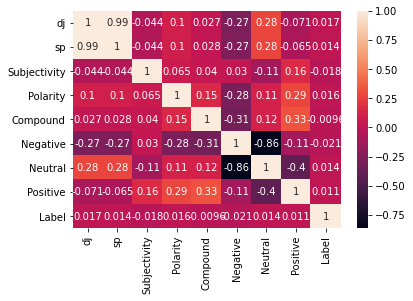

In [195]:
sns.heatmap(df3.corr(), annot=True)

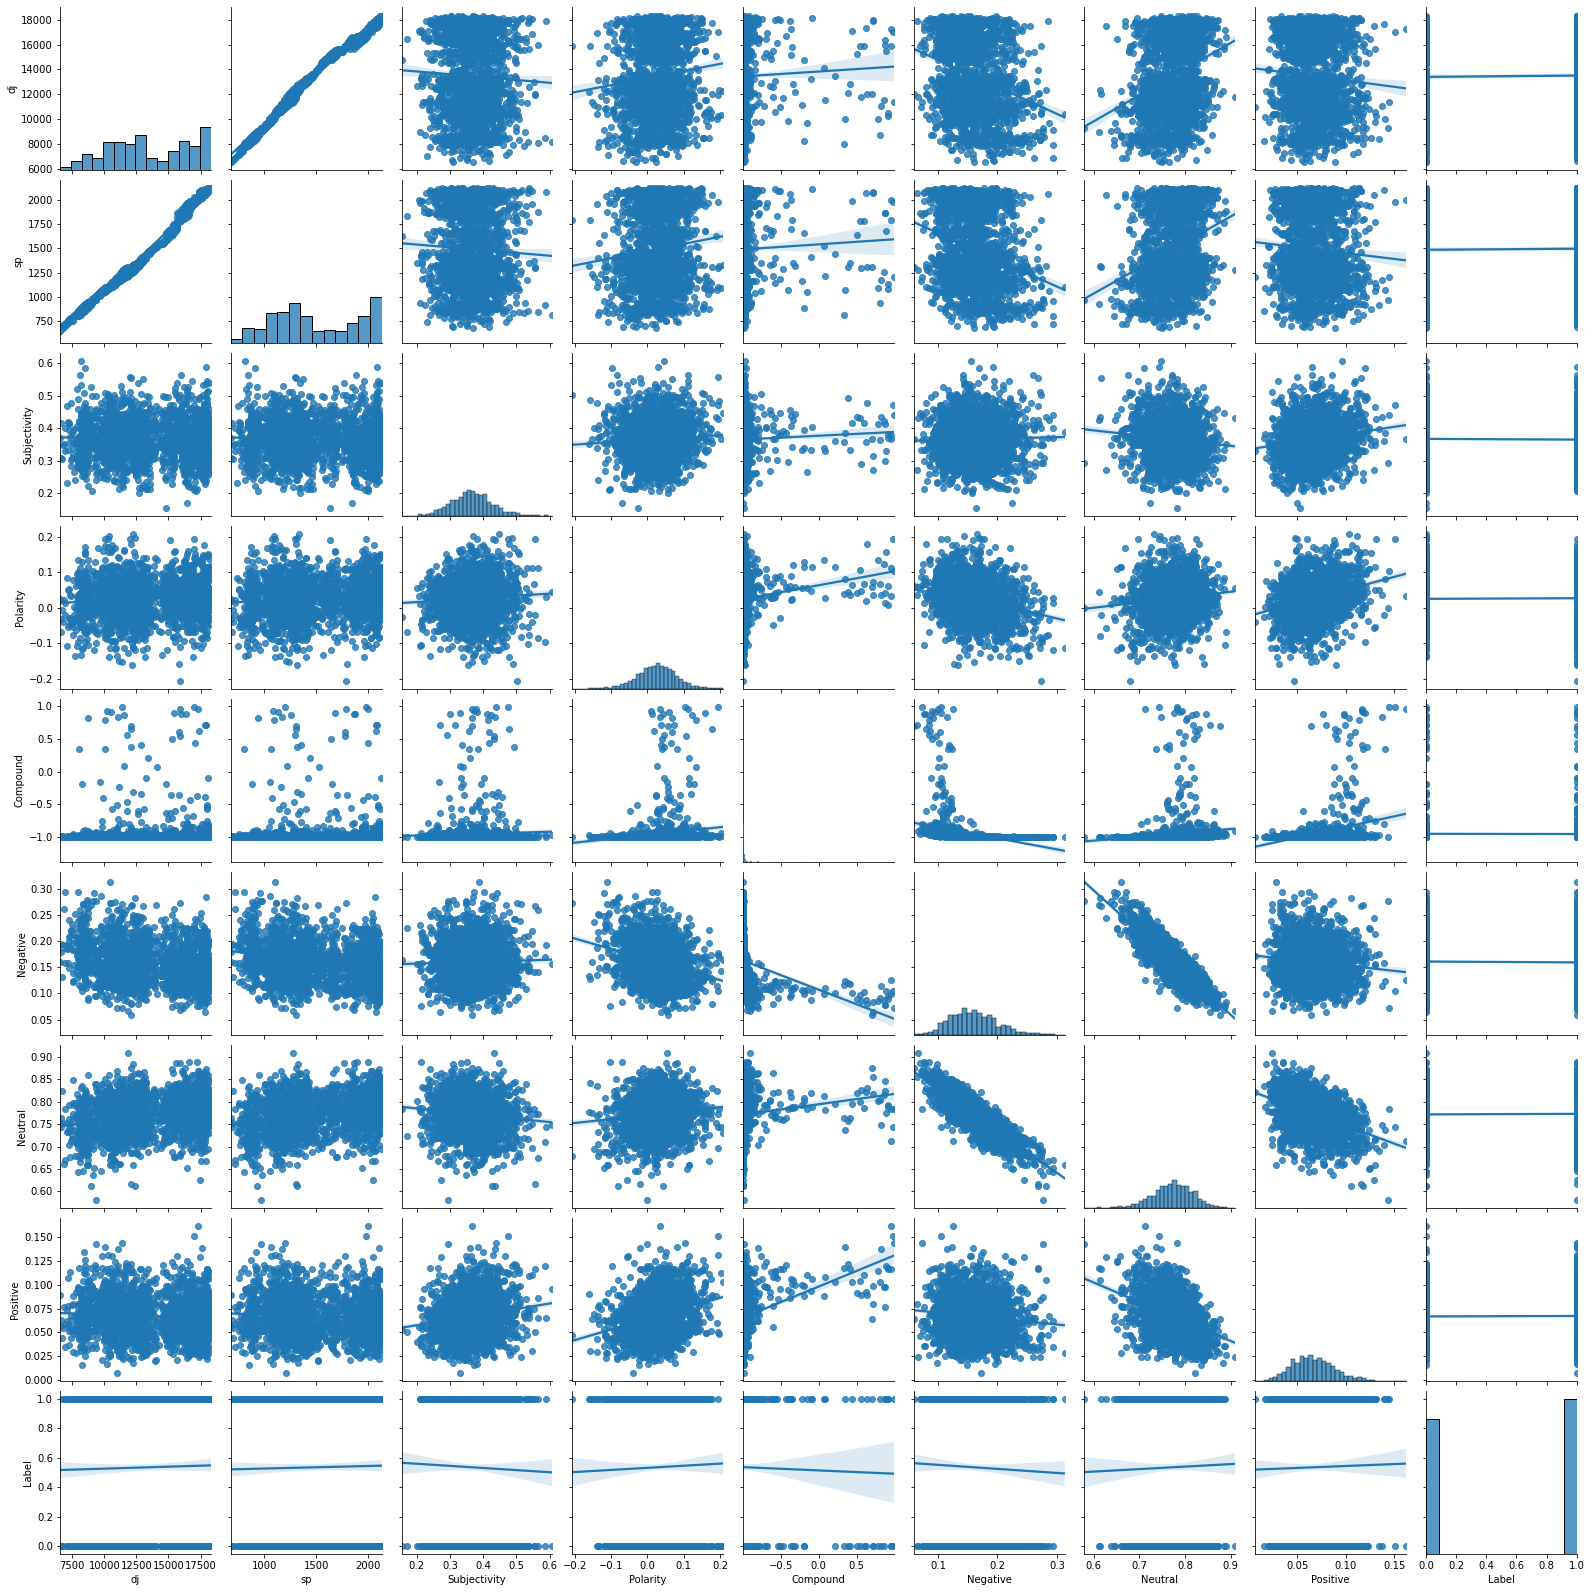

In [196]:
# 페어플랏
sns.pairplot(data=df3, vars=df3.columns, kind='reg')

### 기초통계 확인 결과
- Compount 첨도 매우 큼 (leptokurtic or fat-tail)
- Neutral과 Negative 상관관계 매우 높음

### Target, Feature 선정

In [197]:
X = df3
X = np.array(df3[['Subjectivity', 'Polarity', 'Compound', 'Negative', 'Neutral', 'Positive']])
y = np.array(df3['Label']) # 다우존스 종가 전날대비 상승=1, 아니면 0

In [198]:
# 80% train set, 20% test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=0)

## 선형판별분석 (LDA)
Linear Discriminant Analysis
- 각 클래스의 평균과 분산 추정
    - 가정1. 데이터는 정규분포를 따른다.
    - 가정2. 모든 속성의 분산이 동일하고 각 변수 값들이 평균 주변에 모여 있다.
    - "베이즈정리 이용해 Discriminant score 계산"

In [201]:
#훈련 데이터 셋으로 모형 추정
model = LinearDiscriminantAnalysis().fit(X_train, y_train)

In [203]:
# test set으로 예측값 계산
predictions = model.predict(X_test)

In [205]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.32      0.04      0.07       193
           1       0.51      0.93      0.65       205

    accuracy                           0.49       398
   macro avg       0.41      0.48      0.36       398
weighted avg       0.41      0.49      0.37       398



## 분류기 성과 비교
분류기 성과 비교를 위한 조건 일치시키기
- start_date = '2013'
- end_date = '2016'
- lookback_period = 420
- target = 'Label'
- Features = Subjectivity, Polarity, Compound, Negative, Neutral, Positive

### 분류기반 모형의 성과척도
모형 성과 비교시 **정확도** 및 **F1 Score**에 가중치를 두고 비교
- 정확도(Accuracy)
    - 전체 중에서 모형을 바르게 분류한 비율
    - $\frac{TP+TN}{TP+TN+FP+FN}$
- 정밀도(precision)
    - 모형이 positive라고 분류한 것 중 실제로 positive인 비율
    - $\frac{TP}{TP+FP}$
- 재현율(Recall)
    - data값이 positive인 것 중에서 모형이 positive로 분류한 비율
    - $\frac{TP}{TP+FN}=TPR=1-FNR$
- F1 Score
    - 정밀도와 재현율의 조합평균
    - $\frac{2*Precision*Recall}{Precision+Recall}$

### Logistic Regression Classifier
- accuracy_score = 0.53
- precision_score = 0.54
- recall_score = 0.96
- F1_score = 0.69

### Support Vector Classifier
- accuracy_score = 0.52
- precision_score = 0.53
- recall_score = 0.93
- F1_score = 0.68

### Stochastic Gradient Descent
- accuracy_score = 0.50
- precision_score = 0.54
- recall_score = 0.53
- F1_score = 0.53

### LDA
- accuracy_score = 0.53
- precision_score = 0.54
- recall_score = 0.79
- F1_score = 0.64

### QDA (Quadratic Discriminant Analysis)
- accuracy_score = 0.50
- precision_score = 0.53
- recall_score = 0.70
- F1_score = 0.60

### KNN (K-Nearest Neighbors) classifier
- accuracy_score = 0.52
- precision_score = 0.56
- recall_score = 0.57
- F1_score = 0.56

## 종합 평가
종합 1위 Logistic Regressor / 2위 SVC
- Accuracy Score : Logistic Regressor
- Precision Score : KNN
- Recall Score : Logistic Regressor, SVC
- F1 Score : Logistic Regressor, SVC

